In [2]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from traj_opt import TrajOpt
from scipy.optimize import minimize, Bounds, NonlinearConstraint
import time

import matplotlib.animation as animation
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

In [14]:
ndof = 7
num_via = 2
l = 0.1# * np.ones(ndof)

### Task setup

In [16]:
q_low = - 2.8 * np.ones(ndof)
q_low[0] = 0.0
q_high = 2.8 * np.ones(ndof)
dq_lim = 0.1
ddq_lim = 2.0

x_obs = np.array([0.1, 0.5])
r_obs = 0.1
r_obs_sq = r_obs**2
d_thresh_sq = 0.02**2

#q_0 = np.random.uniform(0.5*q_low, 0.5*q_high)
#q_0[0] += np.pi/2.
q_0 = np.array([2.62008124, -0.2, 0.54976047, -1.09400484, -1.11917744, 0.32662516, 1.19589218])
x_des = np.array([0.5, 0.3, np.pi/4])

dq_0 = np.zeros(ndof)
dq_T = np.zeros(ndof)

T = 5.0
h = T * np.ones(num_via) / num_via

to = TrajOpt(ndof)
to.setup_task(h)

dt_cost = 0.1
t_cost_array = np.linspace(0, T, int(T/dt_cost))

### Forward Kinematics

In [5]:
def fk(q):
    T = np.tril(np.ones([ndof, ndof]))
    T2 = np.tril(np.matlib.repmat(l*np.ones(ndof), ndof, 1))
    f = np.vstack(( 
        T2 @ np.cos(T@q),
        T2 @ np.sin(T@q)
        )).T
    f = np.vstack(( 
        np.zeros(2),
        f
        ))
    return f

def jac(q):
    J = np.zeros((ndof+1, 3, ndof))
    for n in range(ndof):
        J[n+1, 0, :n+1] = J[n, 0, :n+1] - l*np.sin(np.sum(q[:n+1]))*np.ones(n+1)
        J[n+1, 1, :n+1] = J[n, 1, :n+1] + l*np.cos(np.sum(q[:n+1]))*np.ones(n+1)
        J[n+1, 2, :n+1] = 1.
    return J

### Cost and constraints

In [6]:
dqTdp = np.zeros((ndof, num_via*ndof))
dqTdp[:,-ndof:] = np.eye(ndof)

def target_cost(p):
    q = p[-ndof:]
    x = fk(q)[-1]
    e_pos = x[:2] - x_des[:2]
    e_rot = np.sum(q) - x_des[2]
    return e_pos.dot(e_pos) + 0.1 * e_rot**2

def target_grad(p):
    q = p[-ndof:]
    x = fk(q)[-1]
    e_pos = x[:2] - x_des[:2]
    e_rot = np.sum(q) - x_des[2]
    dcdx = 2.0 * np.concatenate((e_pos, [0.1 * e_rot]))
    dxdq = jac(q)[-1]
    return dcdx @ dxdq @ dqTdp

In [18]:
ddPhi = to.get_ddPhi(t_cost_array)
Rw = ddPhi.T @ ddPhi

dwdp = np.zeros(((num_via+3)*ndof, num_via*ndof))
dwdp[ndof:(num_via+1)*ndof] = np.eye(num_via*ndof)

def control_cost(p):
    w = np.concatenate((q_0, p, dq_0, dq_T))
    return w.dot(Rw @ w)

def control_grad(p):
    w = np.concatenate((q_0, p, dq_0, dq_T))
    dcdw = 2.0 * w @ Rw
    return dcdw @ dwdp

[[  4.99591837  -7.99346939   2.99755102   7.59183673  -2.59591837]
 [ -7.99346939  15.98693878  -7.99346939 -10.1877551   10.1877551 ]
 [  2.99755102  -7.99346939   4.99591837   2.59591837  -7.59183673]
 [  7.59183673 -10.1877551    2.59591837  14.73469388  -2.24489796]
 [ -2.59591837  10.1877551   -7.59183673  -2.24489796  14.73469388]]


In [7]:
def obstacle_cost(p):
    q_list = to.get_y(t_cost_array, np.concatenate((q_0, p)), dq_0, dq_T)
    c = 0.0
    for q in q_list:
        x = fk(q)
        for x_ in x[1:]:
            e = x_[:2] - x_obs
            d = e.dot(e) - r_obs_sq
            if d < d_thresh_sq:
                c += d_thresh_sq - d
    return c / len(q_list)

def obstacle_grad(p):
    w = np.concatenate((q_0, p, dq_0, dq_T))
    Phi_list = to.get_Phi(t_cost_array)
    q_list = (Phi_list @ w).reshape(np.size(t_cost_array), ndof) # to.get_y(t_cost_array, np.concatenate((q_0, p)), dq_0, dq_T)
    grad = np.zeros((1, num_via*ndof))
    for j in range(len(q_list)):
        q = q_list[j]
        Phi = Phi_list[j*ndof:(j+1)*ndof]
        x = fk(q)
        J = jac(q)
        for i in range(ndof):
            x_ = x[i+1,:2]
            J_ = J[i+1,:2]
            e = x_ - x_obs
            d = e.dot(e) - r_obs_sq
            if d < d_thresh_sq:
                grad += - 2.0 * e @ J_ @ Phi @ dwdp
    return grad / len(q_list)

### Sequential least-squares quadratic programming

In [10]:
p_init = np.zeros(num_via*ndof)

for i in range(num_via):
    p_init[i*ndof:(i+1)*ndof] = q_0# np.random.uniform(q_low, q_high)

w_target = 1e0
w_control = 1e-5
w_obstacle = 1e2
fun = lambda p: w_target * target_cost(p) + w_control * control_cost(p) + w_obstacle * obstacle_cost(p)
grad = lambda p: w_target * target_grad(p) + w_control * control_grad(p) + w_obstacle * obstacle_grad(p)

lower_bounds_p = np.zeros(num_via*ndof)
upper_bounds_p = np.zeros(num_via*ndof)
for i in range(num_via):
    lower_bounds_p[i*ndof:(i+1)*ndof] = q_low
    upper_bounds_p[i*ndof:(i+1)*ndof] = q_high

bound = Bounds(lower_bounds_p, upper_bounds_p, keep_feasible=True)

In [11]:
def plot_robot(ax, x, c):
    ax.plot(x[:,0], x[:,1], lw=3, color=c)
    ax.scatter(x[:,0], x[:,1], s=100, color=c)

(-0.01, 0.8)

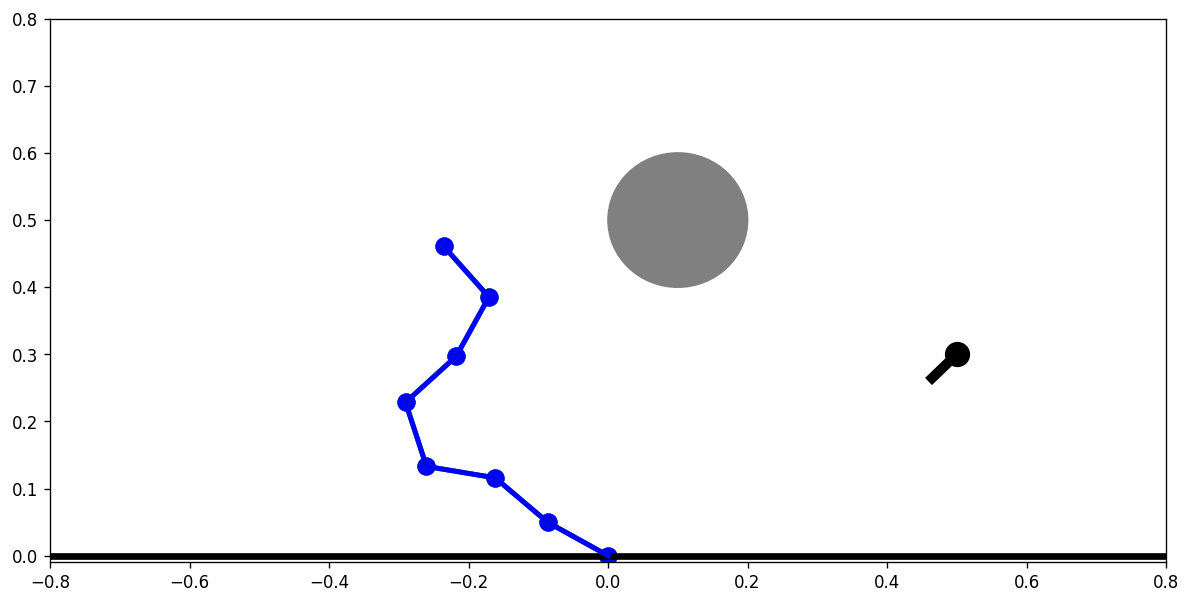

In [12]:
fig, ax = plt.subplots(figsize=(12, 6), dpi= 120, facecolor='w', edgecolor='k')
    
# table line
ax.plot([-2., 2.], [0., 0.], lw=4, color='k')

# obstacle
obs = plt.Circle(x_obs, r_obs, color='grey')
ax.add_patch(obs)

ax.scatter(x_des[0], x_des[1], c='k', s=200)
ax.plot([x_des[0], x_des[0] - l/2 * np.cos(x_des[2])], [x_des[1], x_des[1] - l/2 * np.sin(x_des[2])], 'k', lw=6)

# draw robot links, joints and end effector
plot_robot(ax, fk(q_0), 'g')

q = to.get_y(t_cost_array, np.concatenate((q_0, p_init), axis=0), dq_0, dq_T)
plot_robot(ax, fk(q[-1]), 'b')

K = len(q)

# forward kinematics
Xs = np.zeros((K, ndof+1, 2))

for k in range(K):
    Xs[k] = fk(q[k])

ax.plot(Xs[:,-1,0], Xs[:,-1,1], 'g--')

axes = plt.gca()
axes.set_xlim([-0.8,0.8])
axes.set_ylim([-0.01,0.8])

In [13]:
start = time.time()

#res = minimize(fun, p_init, method='SLSQP', bounds=bound, options={'disp': True})
res = minimize(fun, p_init, method='SLSQP', jac=grad, bounds=bound, options={'ftol': 1e-6, 'disp': True})

# max_iter = 100
# p = p_init.copy()
# for i in range(max_iter):
#     dp = 1e-3 * grad(p)[0]
#     cost0 = fun(p)
#     alpha = 1.0
#     while True:
#         p_tmp = p - alpha * dp
#         cost = fun(p_tmp)
#         if cost < cost0 or alpha < 1e-2:
#             p = p_tmp
#             print("Iteration {}, cost: {}, alpha: {}".format(i, cost, alpha))
#             break
#         alpha /= 2

#     if np.linalg.norm(alpha*dp) < 1e-3:
#         break

duration = time.time()-start

print("Elapsed time: ", duration," [s]")

#print(res.x, get_dq_max(res.x), get_ddq_max(res.x))
q_via = res.x

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00012305125731774217
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30
Elapsed time:  1.6198647022247314  [s]


In [15]:
t = np.linspace(0,T,int(1000*T))

q_nodes = np.concatenate((q_0, q_via), axis=0)

q = to.get_y(t, q_nodes, dq_0, dq_T)
dq = to.get_dy(t, q_nodes, dq_0, dq_T)
ddq = to.get_ddy(t, q_nodes, dq_0, dq_T)

q_nodes = q_nodes.reshape((num_via+1, ndof))

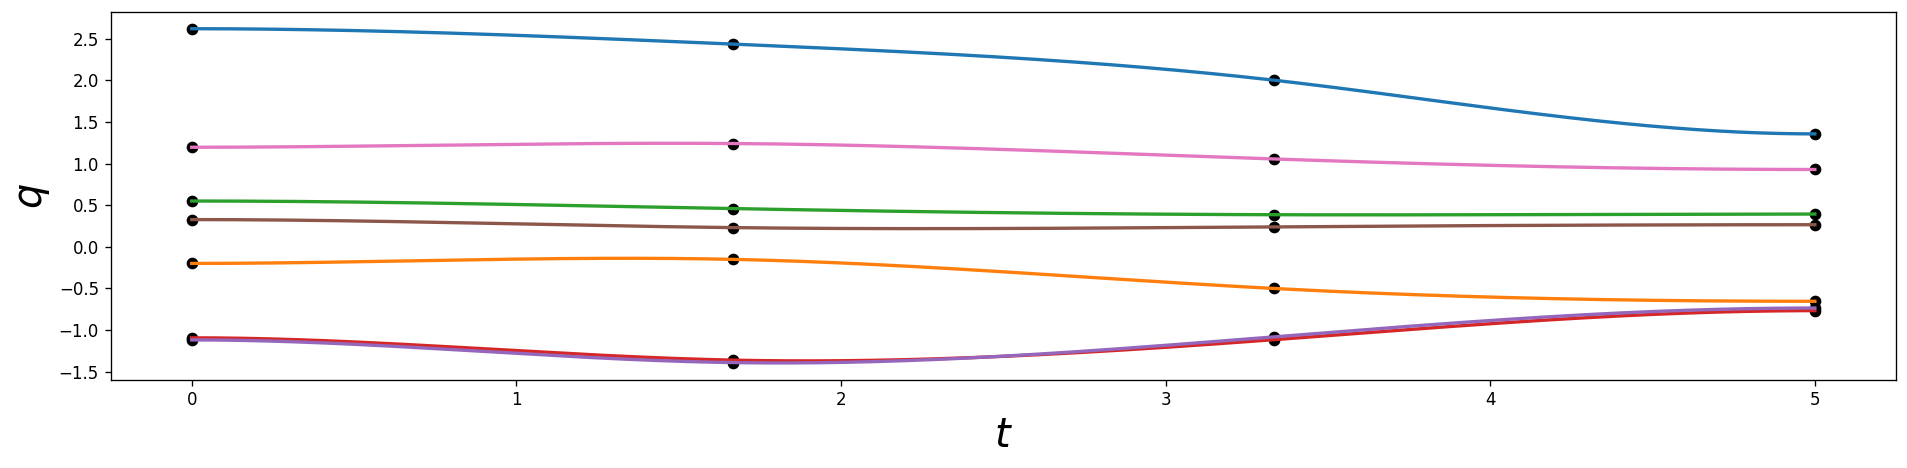

In [16]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$q$', fontsize=fontsize_)

plt.plot(t, q, lw=lw_)

for n in range(num_via+1):
    plt.scatter(np.sum(h[:n])*np.ones(ndof), q_nodes[n], color='k')
    
plt.tight_layout()
#plt.savefig("space_time_optimal_y.png")

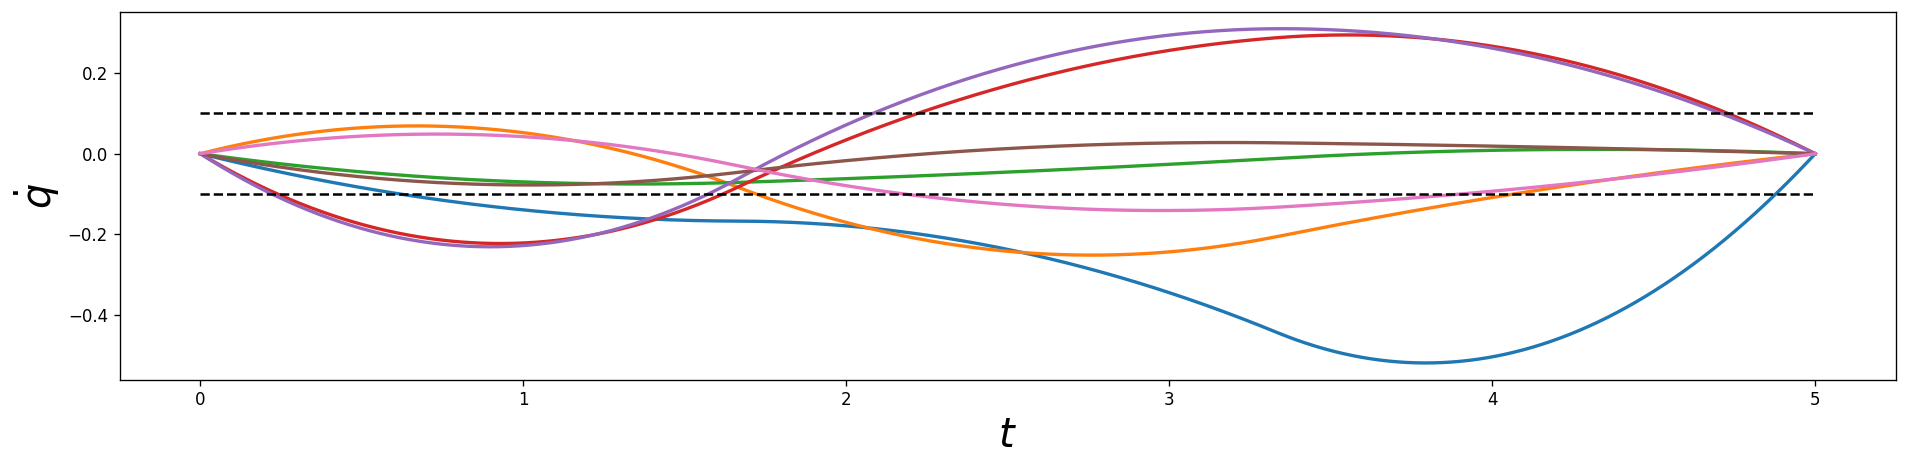

In [17]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$\dot{q}$', fontsize=fontsize_)

plt.plot(t, dq, lw=lw_)

plt.plot([0,T], [dq_lim, dq_lim], 'k--')
plt.plot([0,T], [-dq_lim, -dq_lim], 'k--')

plt.tight_layout()
#plt.savefig("space_time_optimal_dq.png")

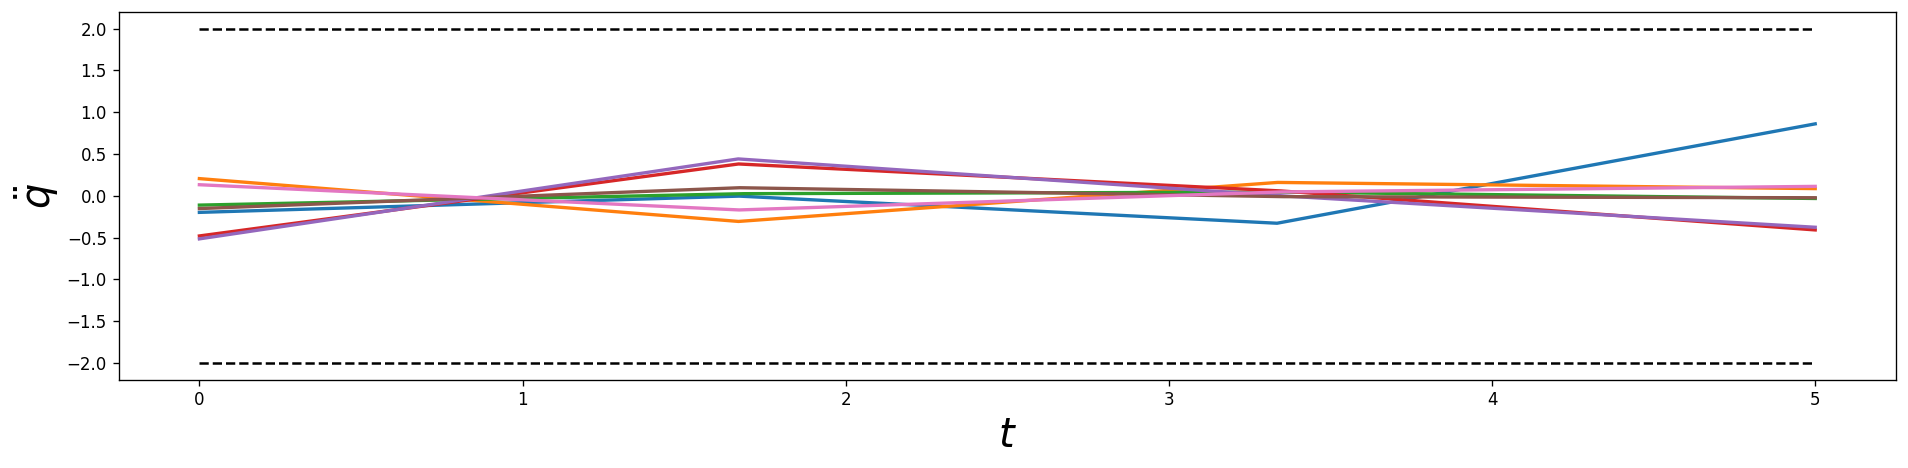

In [18]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$\ddot{q}$', fontsize=fontsize_)

plt.plot(t, ddq, lw=lw_)

plt.plot([0,T], [ddq_lim, ddq_lim], 'k--')
plt.plot([0,T], [-ddq_lim, -ddq_lim], 'k--')

plt.tight_layout()
#plt.savefig("space_time_optimal_ddq.png")

## Visualize the Robot from an array of configurations

(-0.01, 0.8)

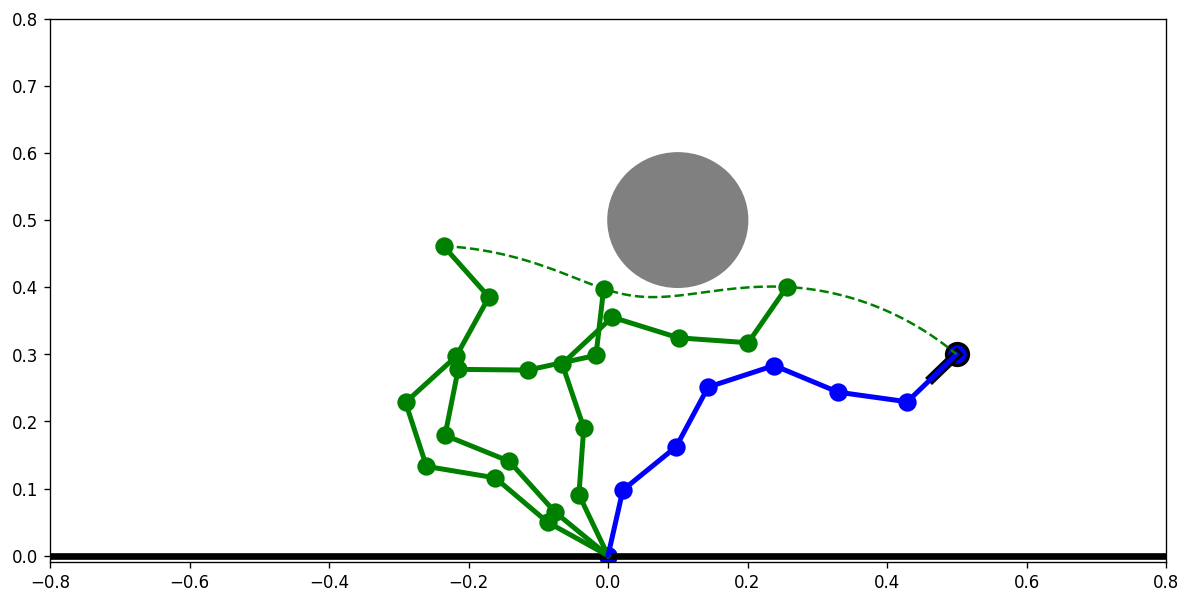

In [19]:
fig, ax = plt.subplots(figsize=(12, 6), dpi= 120, facecolor='w', edgecolor='k')

K = len(q)

# forward kinematics
Xs = np.zeros((K, ndof+1, 2))

for k in range(K):
    q_ = q[k]
    Xs[k] = fk(q_)
    
# table line
ax.plot([-2., 2.], [0., 0.], lw=4, color='k')

# obstacle
obs = plt.Circle(x_obs, r_obs, color='grey')
ax.add_patch(obs)

ax.scatter(x_des[0], x_des[1], c='k', s=200)
ax.plot([x_des[0], x_des[0] - l/2 * np.cos(x_des[2])], [x_des[1], x_des[1] - l/2 * np.sin(x_des[2])], 'k', lw=6)

# draw robot links, joints and end effector
for i in range(num_via):
    plot_robot(ax, fk(q_nodes[i]), 'g')
plot_robot(ax, Xs[-1], 'b')
ax.plot(Xs[:,-1,0], Xs[:,-1,1], 'g--')

axes = plt.gca()
axes.set_xlim([-0.8,0.8])
axes.set_ylim([-0.01,0.8])

# def animate(i_):
#     i = int(i_*dt_ani/dt)
#     link_plot.set_xdata(Xs[i,:,0])
#     link_plot.set_ydata(Xs[i,:,1])
#     joint_plot.set_offsets(Xs[i,:-1,:])
#     ee_plot.set_offsets(Xs[i,-1,:])
#     return link_plot, joint_plot, ee_plot

#ani = animation.FuncAnimation(
#    fig, animate, interval=dt_ani*1e3, blit=True, frames=int(T/dt_ani), repeat=False)

#HTML(ani.to_html5_video())